In [27]:
import numpy as np
from matplotlib import pyplot

L = 5


# problem constants. I set them casually and they can be changed here.
m2 = -4 # mass parameter
lamb = 6 # coupling lambda
mf = 00 # fermion mass 
g = 0.1 # Yukawa coupling



# total mcmc steps
T = 150000

def delta(x):
  if x == 0:
    return 1
  if x == L + 1 or x == - L - 1:
    return -1
  else:
    return 0


# Boson action
def Sb(phi):
  partial_sum = 0
  for x in range(L):
    partial_sum += - 2 * phi[x] * phi[x+1] + (m2 + 2) * phi[x] * phi[x] + lamb * phi[x]**4
  partial_sum += (m2 + 2) * phi[L] * phi[L] + lamb * phi[L]**4
  return partial_sum



# D operator
def D_op(phi):
  D = np.zeros([L+1, L+1])
  for x in range(L + 1):
    for y in range(L + 1):
      D[x][y] = (delta(x-y+1) - delta(x-y-1)) / 2 + delta(x - y) * (mf + g * phi[x])
  return D



# Pseudofermion action
def Spf(phi, varphi):
  D = D_op(phi)  
  DDinverse_varphi = np.linalg.solve(np.matmul(D, D.transpose()), varphi)
  return np.dot(varphi, DDinverse_varphi)
  #DDinverse = np.linalg.inv(np.matmul(D, D.transpose()))

  #partial_sum = 0
  #for x in range(L + 1):
  #  for y in range(L + 1):
  #    partial_sum += varphi[x] * DDinverse[x][y] * varphi[y]
  #return partial_sum

# the potential of the target distribution. pot(phi, varphi)
def pot(phi, varphi):
  return Sb(phi) + Spf(phi, varphi)


# the actual density is proportional to exp(-pot(phi, varphi))
def density(phi, varphi):
  return np.exp(-pot(phi, varphi))

# the marginal density of phi, up to a multiplicative constant
def marg_density(phi):
  D = D_op(phi)
  return np.exp(-Sb(phi)) * (np.linalg.det(D) * np.linalg.det(D)) # should be multiply instead of divide: our midway report was wrong



marginal vs. joint but repeat many times & incl. the *time* axis

In [56]:
import numpy as np
import time
import pickle
from matplotlib import pyplot

L = 5


# problem constants. I set them casually and they can be changed here.
m2 = -4 # mass parameter
lamb = 6 # coupling lambda
mf = 00 # fermion mass 
g = 0.1 # Yukawa coupling



# total mcmc steps
T = 160000

def delta(x):
  if x == 0:
    return 1
  if x == L + 1 or x == - L - 1:
    return -1
  else:
    return 0


# Boson action
def Sb(phi):
  partial_sum = 0
  for x in range(L):
    partial_sum += - 2 * phi[x] * phi[x+1] + (m2 + 2) * phi[x] * phi[x] + lamb * phi[x]**4
  partial_sum += (m2 + 2) * phi[L] * phi[L] + lamb * phi[L]**4
  return partial_sum

# Pseudofermion action
def Spf(phi, varphi):
  D = np.zeros([L+1, L+1])
  for x in range(L + 1):
    for y in range(L + 1):
      D[x][y] = (delta(x-y+1) - delta(x-y-1)) / 2 + delta(x - y) * (mf + g * phi[x])

  
  DDinverse_varphi = np.linalg.solve(np.matmul(D, D.transpose()), varphi)
  return np.dot(varphi, DDinverse_varphi)
  #DDinverse = np.linalg.inv(np.matmul(D, D.transpose()))

  #partial_sum = 0
  #for x in range(L + 1):
  #  for y in range(L + 1):
  #    partial_sum += varphi[x] * DDinverse[x][y] * varphi[y]
  #return partial_sum

# the potential of the target distribution. pot(phi, varphi)
def pot(phi, varphi):
  return Sb(phi) + Spf(phi, varphi)


# the actual density is proportional to exp(-pot(phi, varphi))
def density(phi, varphi):
  return np.exp(-pot(phi, varphi))

# the marginal density of phi, up to a multiplicative constant
def marg_density(phi):
  D = np.zeros([L+1, L+1])
  for x in range(L + 1):
    for y in range(L + 1):
      D[x][y] = (delta(x-y+1) - delta(x-y-1)) / 2 + delta(x - y) * (mf + g * phi[x])
  return np.exp(-Sb(phi)) * (np.linalg.det(D) * np.linalg.det(D)) # should be multiply instead of divide: our midway report was wrong



# repeat some times to get many trajectories
repeat_num = 10

observabless_marg = [ ]
timess_marg = [ ]

observabless_joint = [ ]
timess_joint = [ ]


# for scatterplot
x_coords_marg = [ ]
y_coords_marg = [ ]
x_coords_joint = [ ]
y_coords_joint = [ ]


for rep in range(repeat_num):
  # Metropolis-Hastings on the marginal of phi
  observables = [ ]
  observables_sum = 0
  avg_observables_marginal = [ ]
  times = [ ]
  phi = np.random.normal(0, 1, L + 1)

  start = time.time()
  for time_ in range(T):
    # proposal N(0, 1)
    phi_next = np.random.normal(phi, 0.1)
    # accept probability
    acc_prob = marg_density(phi_next) / marg_density(phi)
    if np.random.uniform() > acc_prob:
      # reject
      pass
    else:
      # accept
      phi = phi_next

    # calculate the observable
    observable = np.abs(sum(phi) / (L+1))
    observables.append(observable)
    observables_sum += observable

    if time_ % 1000 == 999:
      avg_observables_marginal.append(observables_sum / (time_ + 1))
      times.append(time.time() - start)

    if time_ % 50 == 49:
      if rep == 0:
        x_coords_marg.append(phi[1])
        y_coords_marg.append(phi[3])
  
  observabless_marg.append(avg_observables_marginal)
  timess_marg.append(times)


  # Metropolis-Hastings on the joint phi and varphi
  observables = [ ]
  observables_sum = 0
  avg_observables_joint = [ ]
  times = [ ]
  phi = np.random.normal(0, 1, L + 1)
  varphi = np.random.normal(0, 1, L + 1)

  start = time.time()
  for time_ in range(T):
    # proposal N(0, 1)
    phi_next = np.random.normal(phi, 0.1)
    varphi_next = np.random.normal(varphi, 0.1)
    # accept probability
    acc_prob = density(phi_next, varphi_next) / density(phi, varphi)
    if np.random.uniform() > acc_prob:
      # reject
      pass
    else:
      # accept
      phi = phi_next
      varphi = varphi_next

    # calculate the observable
    observable = np.abs(sum(phi) / (L+1))
    observables.append(observable)
    observables_sum += observable

    if time_ % 1000 == 999:
      avg_observables_joint.append(observables_sum / (time_ + 1))
      times.append(time.time() - start)


    if time_ % 50 == 49:
      if rep == 0:
        x_coords_joint.append(phi[1])
        y_coords_joint.append(phi[3])

  observabless_joint.append(avg_observables_joint)
  timess_joint.append(times)










savetraj = True
savesactter = True

if savetraj:

  fig, (ax_steps, ax_times) = pyplot.subplots(2, 1, figsize=(8,7))
  # make a little extra space between the subplots
  fig.subplots_adjust(hspace=0.5)
  fig.suptitle("Trajectories of the empirical average of the observable: Metropolis-Hastings")



  for rep in range(repeat_num):
    ax_steps.plot(observabless_marg[rep], lw=0.35, c="red", label="marginal sampling" if rep == 0 else None)
    ax_steps.plot(observabless_joint[rep], lw=0.35, c="blue", label="joint sampling" if rep == 0 else None)
  ax_steps.set_xlabel("thousand MCMC steps")
  ax_steps.legend()
  ax_steps.set_ylim((0,0.4))
  ax_steps.grid()



  for rep in range(repeat_num):
    ax_times.plot(timess_marg[rep], observabless_marg[rep], lw=0.35, c="red", label="marginal sampling" if rep == 0 else None)
    ax_times.plot(timess_joint[rep], observabless_joint[rep], lw=0.35, c="blue", label="joint sampling" if rep == 0 else None)
  ax_times.set_xlabel("time elapsed (seconds)")
  ax_times.legend()
  ax_times.set_ylim((0,0.4))
  ax_times.grid()



  pyplot.savefig("marginal-vs-joint-full.pdf", bbox_inches='tight')
  from google.colab import files
  files.download("marginal-vs-joint-full.pdf")

  # save data
  exp_data = {  
    "observabless_marg": observabless_marg,
    "timess_marg": timess_marg,
    "observabless_joint": observabless_joint,
    "timess_joint": timess_joint
  }


  with open('mvjdata.p', 'wb') as fp:
    pickle.dump(exp_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

if savesactter:
  sc_data = {
      "x_coords_marg": x_coords_marg,
      "y_coords_marg": y_coords_marg,
      "x_coords_joint": x_coords_joint,
      "y_coords_joint": y_coords_joint
  }

  with open('mvjscatter.p', 'wb') as fp:
    pickle.dump(sc_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

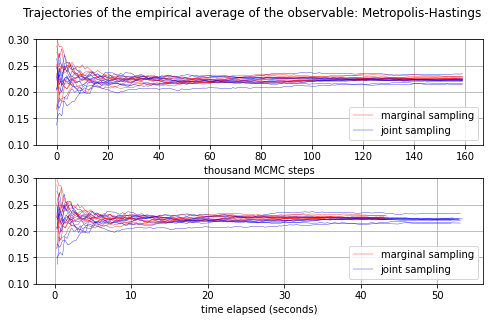

In [56]:
# redraw figures


with open('mvjdata.p', 'rb') as fp:
  mvj_data = pickle.load(fp)

# load data
observabless_marg = mvj_data["observabless_marg"]
timess_marg = mvj_data["timess_marg"]
observabless_joint = mvj_data["observabless_joint"]
timess_joint = mvj_data["timess_joint"]



fig, (ax_steps, ax_times) = pyplot.subplots(2, 1, figsize=(8,4.5))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.32)
fig.suptitle("Trajectories of the empirical average of the observable: Metropolis-Hastings")



for rep in range(repeat_num):
  ax_steps.plot(observabless_marg[rep], lw=0.35, c="red", label="marginal sampling" if rep == 0 else None)
  ax_steps.plot(observabless_joint[rep], lw=0.35, c="blue", label="joint sampling" if rep == 0 else None)
ax_steps.set_xlabel("thousand MCMC steps")
ax_steps.legend()
ax_steps.set_ylim((0.1,0.3))
ax_steps.grid()



for rep in range(repeat_num):
  ax_times.plot(timess_marg[rep], observabless_marg[rep], lw=0.35, c="red", label="marginal sampling" if rep == 0 else None)
  ax_times.plot(timess_joint[rep], observabless_joint[rep], lw=0.35, c="blue", label="joint sampling" if rep == 0 else None)
ax_times.set_xlabel("time elapsed (seconds)")
ax_times.legend()
ax_times.set_ylim((0.1,0.3))
ax_times.grid()



pyplot.savefig("marginal-vs-joint-full.pdf", bbox_inches='tight')
from google.colab import files
files.download("marginal-vs-joint-full.pdf")



Gradients

In [ ]:
# useless: modulization hurts performance!

def grad_Sb_phi(phi):
  _grad_Sb_phi = np.zeros(L+1)
  for z in range(L+1):
    _grad_Sb_phi[z] = 2*(m2 + 2) * phi[z] + 4*lamb*(phi[z]**3)
    if z > 0:
      _grad_Sb_phi[z] -= 2 * phi[z - 1]
    if z < L:
      _grad_Sb_phi[z] -= 2 * phi[z + 1]
  return _grad_Sb_phi



def grad_Spf_varphi(phi, varphi):
  D = D_op(phi)  
  DDinverse_varphi = np.linalg.solve(np.matmul(D, D.transpose()), varphi)
  return 2 * DDinverse_varphi


def grad_Spf_phi(phi, varphi):
  pass

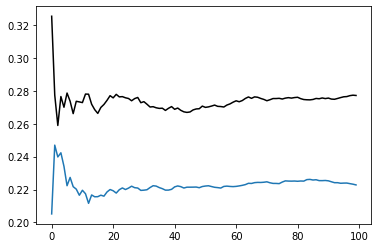

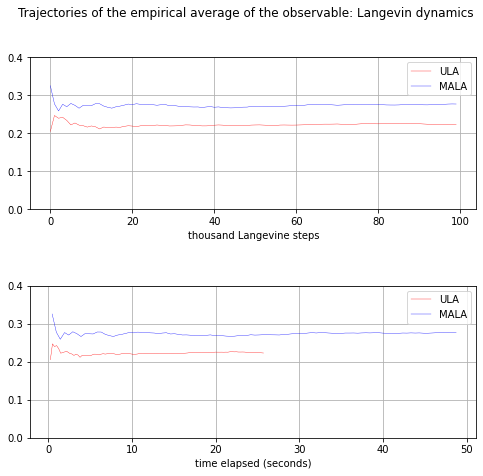

In [57]:
import time
repeat_num = 10

observabless_ula = [ ]
timess_ula = [ ]

observabless_mala = [ ]
timess_mala = [ ]

# langevin steps
T = 100000

# langevin step size
gamma = 0.01


# for scatterplot
x_coords = [ ]
y_coords = [ ]



#### MALA is incorrectly implemented here!!!!!
#### use only ULA



for rep in range(repeat_num):
  # ULA on the joint
  observables = [ ]
  observables_sum = 0
  avg_observables_ula = [ ]
  times = [ ]
  phi = np.random.normal(0, 1, L + 1)
  varphi = np.random.normal(0, 1, L + 1)

  start = time.time()
  for time_ in range(T):
    # langevin iteration


    # calculating gradients 
    grad_Sb_phi = np.zeros(L+1)
    for z in range(L+1):
      grad_Sb_phi[z] = 2*(m2 + 2) * phi[z] + 4*lamb*(phi[z]**3)
      if z > 0:
        grad_Sb_phi[z] -= 2 * phi[z - 1]
      if z < L:
        grad_Sb_phi[z] -= 2 * phi[z + 1]

    
    D = D_op(phi)
    DDtranspose = np.matmul(D, D.transpose())
    DDinverse_varphi = np.linalg.solve(DDtranspose, varphi)
    grad_Spf_varphi = 2 * DDinverse_varphi


    grad_Spf_phi = np.zeros(L+1)
    MM = g * D.transpose()
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    for z in range(L+1):
      if z > 0 or z < L:
        grad_Spf_phi[z] = np.dot(varphi, K_varphi)

    # z=0
    MM[0] = MM[0] - MM[L]
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    grad_Spf_phi[0] = np.dot(varphi, K_varphi)

    # z=L
    MM = g * D.transpose()
    MM[L] = MM[L] - MM[0]
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    grad_Spf_phi[L] = np.dot(varphi, K_varphi)


    # update langevin
    phi = np.random.normal(phi - gamma*(grad_Sb_phi + grad_Spf_phi), np.sqrt(2*gamma))
    varphi = np.random.normal(varphi - gamma*grad_Spf_varphi, np.sqrt(2*gamma))
      


    # calculate the observable
    observable = np.abs(sum(phi) / (L+1))
    observables.append(observable)
    observables_sum += observable

    if time_ % 1000 == 999:
      avg_observables_ula.append(observables_sum / (time_ + 1))
      times.append(time.time() - start)

    if time_ % 50 == 49:
      if rep == 0:
        x_coords.append(phi[1])
        y_coords.append(phi[3])
  
  observabless_ula.append(avg_observables_ula)
  timess_ula.append(times)


  pyplot.plot(avg_observables_ula)


  # MALA on the joint
  observables = [ ]
  observables_sum = 0
  avg_observables_mala = [ ]
  times = [ ]
  phi = np.random.normal(0, 1, L + 1)
  varphi = np.random.normal(0, 1, L + 1)

  start = time.time()
  for time_ in range(T):
    # langevin iteration


    # calculating gradients 
    grad_Sb_phi = np.zeros(L+1)
    for z in range(L+1):
      grad_Sb_phi[z] = 2*(m2 + 2) * phi[z] + 4*lamb*(phi[z]**3)
      if z > 0:
        grad_Sb_phi[z] -= 2 * phi[z - 1]
      if z < L:
        grad_Sb_phi[z] -= 2 * phi[z + 1]

    
    D = D_op(phi)
    DDtranspose = np.matmul(D, D.transpose())
    DDinverse_varphi = np.linalg.solve(DDtranspose, varphi)
    grad_Spf_varphi = 2 * DDinverse_varphi


    grad_Spf_phi = np.zeros(L+1)
    MM = g * D.transpose()
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    for z in range(L+1):
      if z > 0 or z < L:
        grad_Spf_phi[z] = np.dot(varphi, K_varphi)

    # z=0
    MM[0] = MM[0] - MM[L]
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    grad_Spf_phi[0] = np.dot(varphi, K_varphi)

    # z=L
    MM = g * D.transpose()
    MM[L] = MM[L] - MM[0]
    MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
    K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
    grad_Spf_phi[L] = np.dot(varphi, K_varphi)


    # update langevin
    phi_next = np.random.normal(phi - gamma*(grad_Sb_phi + grad_Spf_phi), np.sqrt(2*gamma))
    varphi_next = np.random.normal(varphi - gamma*grad_Spf_varphi, np.sqrt(2*gamma))
    

    # accept probability
    acc_prob = density(phi_next, varphi_next) / density(phi, varphi)
    if np.random.uniform() > acc_prob:
      # reject
      pass
    else:
      # accept
      phi = phi_next
      varphi = varphi_next


    # calculate the observable
    observable = np.abs(sum(phi) / (L+1))
    observables.append(observable)
    observables_sum += observable

    if time_ % 1000 == 999:
      avg_observables_mala.append(observables_sum / (time_ + 1))
      times.append(time.time() - start)
  
  observabless_mala.append(avg_observables_mala)
  timess_mala.append(times)
  pyplot.plot(avg_observables_mala, c="black")
  




fig, (ax_steps, ax_times) = pyplot.subplots(2, 1, figsize=(8,7))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Trajectories of the empirical average of the observable: Langevin dynamics")



for rep in range(repeat_num):
  ax_steps.plot(observabless_ula[rep], lw=0.35, c="red", label="ULA" if rep == 0 else None)
  ax_steps.plot(observabless_mala[rep], lw=0.35, c="blue", label="MALA" if rep == 0 else None)
ax_steps.set_xlabel("thousand Langevine steps")
ax_steps.legend()
ax_steps.set_ylim((0,0.4))
ax_steps.grid()



for rep in range(repeat_num):
  ax_times.plot(timess_ula[rep], observabless_ula[rep], lw=0.35, c="red", label="ULA" if rep == 0 else None)
  ax_times.plot(timess_mala[rep], observabless_mala[rep], lw=0.35, c="blue", label="MALA" if rep == 0 else None)
ax_times.set_xlabel("time elapsed (seconds)")
ax_times.legend()
ax_times.set_ylim((0,0.4))
ax_times.grid()



savetraj = True
savesactter = True

if savetraj:

  pyplot.savefig("lang.pdf", bbox_inches='tight')
  from google.colab import files
  files.download("lang.pdf")

  # save data
  exp_data = {  
    "observabless_ula": observabless_ula,
    "timess_ula": timess_ula,
    "observabless_mala": observabless_mala,
    "timess_mala": timess_mala
  }


  with open('langdata.p', 'wb') as fp:
    pickle.dump(exp_data, fp, protocol=pickle.HIGHEST_PROTOCOL)


if savesactter:
  sc_data = {
      "x_coords": x_coords,
      "y_coords": y_coords
  }

  with open('langscatter.p', 'wb') as fp:
    pickle.dump(sc_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

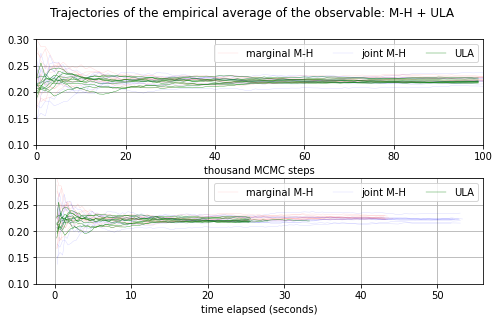

In [48]:
# draw them together

# load data
with open('mvjdata.p', 'rb') as fp:
  mvj_data = pickle.load(fp)


observabless_marg = mvj_data["observabless_marg"]
timess_marg = mvj_data["timess_marg"]
observabless_joint = mvj_data["observabless_joint"]
timess_joint = mvj_data["timess_joint"]


with open('langdata.p', 'rb') as fp:
  lang_data = pickle.load(fp)


observabless_ula = lang_data["observabless_ula"]
timess_ula = lang_data["timess_ula"]
#observabless_mala = lang_data["observabless_mala"]
#timess_mala = lang_data["timess_mala"]



fig, (ax_steps, ax_times) = pyplot.subplots(2, 1, figsize=(8,4.5))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.32)
fig.suptitle("Trajectories of the empirical average of the observable: M-H + ULA")



for rep in range(repeat_num):
  ax_steps.plot(observabless_marg[rep], lw=0.35, c="red", alpha=0.2, label="marginal M-H" if rep == 0 else None)
  ax_steps.plot(observabless_joint[rep], lw=0.35, c="blue", alpha=0.2, label="joint M-H" if rep == 0 else None)
  ax_steps.plot(observabless_ula[rep], lw=0.35, c="green", label="ULA" if rep == 0 else None)
  #ax_steps.plot(observabless_mala[rep], lw=0.35, c="black", label="MALA" if rep == 0 else None)
ax_steps.set_xlabel("thousand MCMC steps")
ax_steps.legend(ncol=4)
ax_steps.set_ylim((0.1,0.3))
ax_steps.set_xlim((0,100))
ax_steps.grid()



for rep in range(repeat_num):
  ax_times.plot(timess_marg[rep], observabless_marg[rep], lw=0.35, c="red", alpha=0.2, label="marginal M-H" if rep == 0 else None)
  ax_times.plot(timess_joint[rep], observabless_joint[rep], lw=0.35, c="blue", alpha=0.2, label="joint M-H" if rep == 0 else None)
  ax_times.plot(timess_ula[rep], observabless_ula[rep], lw=0.35, c="green", label="ULA" if rep == 0 else None)
  #ax_times.plot(timess_mala[rep], observabless_mala[rep], lw=0.35, c="black", label="MALA" if rep == 0 else None)
ax_times.set_xlabel("time elapsed (seconds)")
ax_times.legend(ncol=4)
ax_times.set_ylim((0.1,0.3))
ax_times.grid()



pyplot.savefig("mh-ld.pdf", bbox_inches='tight')
from google.colab import files
files.download("mh-ld.pdf")



try birth-death sampling

In [53]:
import time, pickle

N_part = 20 # number of particles
tick_rounds = 1000 / N_part # record stuffs per k steps

T = 7000
gamma = 0.01

repeat_num = 10

observabless = [ ]
timess = [ ]



h = 0.05 # kernel bandwidth
kernel_factor = 1 / ( (2*np.pi*h*h)**(L+1) )

# kernel
def kern(phi1, varphi1, phi2, varphi2):
  return kernel_factor * np.exp( - (np.dot(phi1 - phi2, phi1 - phi2) + np.dot(varphi1 - varphi2, varphi1 - varphi2)) / (2*h) )





observables = [ ]





# for scatterplot
x_coords = [ ]
y_coords = [ ]



for rep in range(repeat_num):

  avg_observables_lifedeath = [ ]
  times = [ ]
  observables_sum = 0

  phi_s = np.zeros([N_part, L+1]) # each time, there are N_part particles, each of dimension L+1
  varphi_s = np.zeros([N_part, L+1]) # each time, there are N_part particles, each of dimension L+1

  # initialized particles
  for i in range(N_part):
    phi_s[i] = np.random.normal(0, 1, L + 1)
    varphi_s[i] = np.random.normal(0, 1, L + 1)


  start = time.time()
  for _time in range(T):
    for i in range(N_part):
      # langevin step
      phi = phi_s[i]
      varphi = varphi_s[i]

      # calculating gradients 
      grad_Sb_phi = np.zeros(L+1)
      for z in range(L+1):
        grad_Sb_phi[z] = 2*(m2 + 2) * phi[z] + 4*lamb*(phi[z]**3)
        if z > 0:
          grad_Sb_phi[z] -= 2 * phi[z - 1]
        if z < L:
          grad_Sb_phi[z] -= 2 * phi[z + 1]

      
      D = D_op(phi)
      DDtranspose = np.matmul(D, D.transpose())
      DDinverse_varphi = np.linalg.solve(DDtranspose, varphi)
      grad_Spf_varphi = 2 * DDinverse_varphi


      grad_Spf_phi = np.zeros(L+1)
      MM = g * D.transpose()
      MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
      K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
      for z in range(L+1):
        if z > 0 or z < L:
          grad_Spf_phi[z] = np.dot(varphi, K_varphi)

      # z=0
      MM[0] = MM[0] - MM[L]
      MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
      K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
      grad_Spf_phi[0] = np.dot(varphi, K_varphi)

      # z=L
      MM = g * D.transpose()
      MM[L] = MM[L] - MM[0]
      MM_to_right = (MM + MM.transpose()).dot(DDinverse_varphi)
      K_varphi = - np.linalg.solve(DDtranspose, MM_to_right)
      grad_Spf_phi[L] = np.dot(varphi, K_varphi)

      # update langevin
      phi = np.random.normal(phi - gamma*(grad_Sb_phi + grad_Spf_phi), np.sqrt(2*gamma))
      varphi = np.random.normal(varphi - gamma*grad_Spf_varphi, np.sqrt(2*gamma))
      
      phi_s[i] = phi
      varphi_s[i] = varphi



    betas = np.zeros(N_part)
    for i in range(N_part):
      # life-death part
      sum_kern = 0
      for ell in range(N_part):
        if not ell == i:
          sum_kern += kern(phi_s[i], varphi_s[i], phi_s[ell], varphi_s[ell])
      betas[i] = np.log( sum_kern / N_part ) + pot(phi_s[i], varphi_s[i])
    beta_avg = np.mean(betas)
    betas = betas - beta_avg # the beta-bars

    for i in range(N_part):
      if betas[i] > 0:
        # kill the particle #i
        if np.random.uniform() >= np.exp( - betas[i] * gamma):
          # kill
          duplic = np.random.randint(N_part - 1)
          if duplic >= i:
            duplic += 1
          phi_s[i] = phi_s[duplic]
          varphi_s[i] = varphi_s[duplic]
      else:
        # duplicate the particle #i
        if np.random.uniform() >= np.exp(betas[i] * gamma):
          # duplicate
          duplic = np.random.randint(N_part - 1)
          if duplic >= i:
            duplic += 1
          phi_s[duplic] = phi_s[i]
          varphi_s[duplic] = varphi_s[i]

    for i in range(N_part):
      observables_sum += np.abs(np.mean(phi_s[i]))
    if _time % tick_rounds == (tick_rounds - 1):
      if rep == 0:
        for i in range(N_part):
          x_coords.append(phi_s[i][1])
          y_coords.append(phi_s[i][3])

      avg_observables_lifedeath.append(observables_sum / (_time * N_part))
      times.append(time.time() - start)
  
  observabless.append(avg_observables_lifedeath)
  timess.append(times)



savetraj = True
savesactter = True

if savetraj:
  # save data
  exp_data = {  
    "observabless_birthdeath": observabless,
    "timess_birthdeath": timess
  }


  with open('birthdeathdata.p', 'wb') as fp:
    pickle.dump(exp_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

if savesactter:
  sc_data = {
      "x_coords": x_coords,
      "y_coords": y_coords
  }

  with open('birthdeathscatter.p', 'wb') as fp:
    pickle.dump(sc_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

draw them together

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

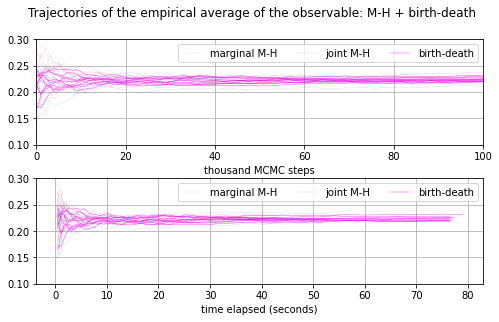

In [55]:
# draw them together

# load data
with open('mvjdata.p', 'rb') as fp:
  mvj_data = pickle.load(fp)


observabless_marg = mvj_data["observabless_marg"]
timess_marg = mvj_data["timess_marg"]
observabless_joint = mvj_data["observabless_joint"]
timess_joint = mvj_data["timess_joint"]


with open('birthdeathdata.p', 'rb') as fp:
  bd_data = pickle.load(fp)


observabless_bd = bd_data["observabless_birthdeath"]
timess_bd = bd_data["timess_birthdeath"]



fig, (ax_steps, ax_times) = pyplot.subplots(2, 1, figsize=(8,4.5))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.32)
fig.suptitle("Trajectories of the empirical average of the observable: M-H + birth-death")



for rep in range(repeat_num):
  ax_steps.plot(observabless_marg[rep], lw=0.35, c="red", alpha=0.2, label="marginal M-H" if rep == 0 else None)
  ax_steps.plot(observabless_joint[rep], lw=0.35, c="blue", alpha=0.2, label="joint M-H" if rep == 0 else None)
  ax_steps.plot(observabless_bd[rep], lw=0.35, c="magenta", label="birth-death" if rep == 0 else None)
  #ax_steps.plot(observabless_mala[rep], lw=0.35, c="black", label="MALA" if rep == 0 else None)
ax_steps.set_xlabel("thousand MCMC steps")
ax_steps.legend(ncol=4)
ax_steps.set_ylim((0.1,0.3))
ax_steps.set_xlim((0,100))
ax_steps.grid()



for rep in range(repeat_num):
  ax_times.plot(timess_marg[rep], observabless_marg[rep], lw=0.35, c="red", alpha=0.2, label="marginal M-H" if rep == 0 else None)
  ax_times.plot(timess_joint[rep], observabless_joint[rep], lw=0.35, c="blue", alpha=0.2, label="joint M-H" if rep == 0 else None)
  ax_times.plot(timess_bd[rep], observabless_bd[rep], lw=0.35, c="magenta", label="birth-death" if rep == 0 else None)
  #ax_times.plot(timess_mala[rep], observabless_mala[rep], lw=0.35, c="black", label="MALA" if rep == 0 else None)
ax_times.set_xlabel("time elapsed (seconds)")
ax_times.legend(ncol=4)
ax_times.set_ylim((0.1,0.3))
ax_times.grid()



pyplot.savefig("mh-bd.pdf", bbox_inches='tight')
from google.colab import files
files.download("mh-bd.pdf")



draw density estimation landscape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

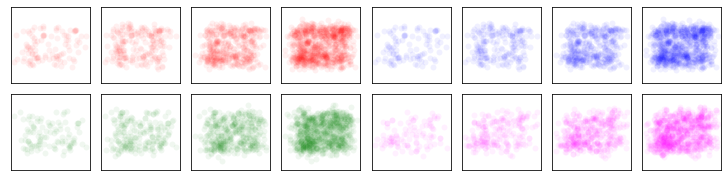

In [82]:
with open('mvjscatter.p', 'rb') as fp:
  mvj_sc = pickle.load(fp)

x_coords_marg = mvj_sc["x_coords_marg"]
y_coords_marg = mvj_sc["y_coords_marg"]
x_coords_joint = mvj_sc["x_coords_marg"]
y_coords_joint = mvj_sc["y_coords_marg"]

with open('langscatter.p', 'rb') as fp:
  lang_sc = pickle.load(fp)

x_coords_lang = lang_sc["x_coords"]
y_coords_lang = lang_sc["y_coords"]

with open('birthdeathscatter.p', 'rb') as fp:
  bd_sc = pickle.load(fp)

x_coords_bd = bd_sc["x_coords"]
y_coords_bd = bd_sc["y_coords"]



fig, axs = pyplot.subplots(2, 8, figsize=(10, 2.4), constrained_layout=True)


points = [ 100, 200, 400, 800 ]
# 5k, 10k, 20k, 40k steps


for k in range(4):
  axs[0][k].scatter(x_coords_marg[:points[k]], y_coords_marg[:points[k]], alpha=0.06, linewidths=0.01, c="red")
  axs[0][k].set_ylim((-1.5,1.5))
  axs[0][k].set_yticks([])
  axs[0][k].set_xticks([])

for k in range(4):
  axs[0][4+k].scatter(x_coords_joint[:points[k]], y_coords_joint[:points[k]], alpha=0.06, linewidths=0.01, c="blue")
  axs[0][4+k].set_ylim((-1.5,1.5))
  axs[0][4+k].set_yticks([])
  axs[0][4+k].set_xticks([])

for k in range(4):
  axs[1][k].scatter(x_coords_lang[:points[k]], y_coords_lang[:points[k]], alpha=0.06, linewidths=0.01, c="green")
  axs[1][k].set_ylim((-1.5,1.5))
  axs[1][k].set_yticks([])
  axs[1][k].set_xticks([])

for k in range(4):
  axs[1][4+k].scatter(x_coords_bd[:points[k]], y_coords_bd[:points[k]], alpha=0.06, linewidths=0.01, c="magenta")
  axs[1][4+k].set_ylim((-1.5,1.5))
  axs[1][4+k].set_yticks([])
  axs[1][4+k].set_xticks([])


pyplot.savefig("landscape.pdf", bbox_inches='tight')
from google.colab import files
files.download("landscape.pdf")

mid-way legacy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

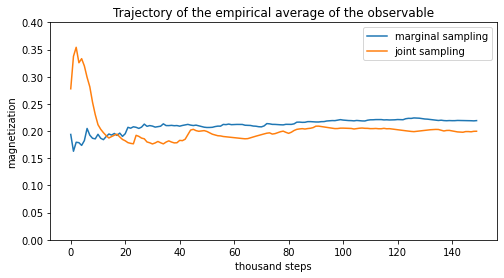

In [ ]:
pyplot.figure(figsize = (8,4))
pyplot.title("Trajectory of the empirical average of the observable")
pyplot.plot(avg_observables_marginal, label="marginal sampling")
pyplot.plot(avg_observables_joint, label="joint sampling")
pyplot.xlabel("thousand steps")
pyplot.ylabel("magnetization")
pyplot.ylim((0,0.4))
pyplot.legend()
pyplot.savefig("marginal-vs-joint.pdf", bbox_inches='tight')

from google.colab import files
files.download("marginal-vs-joint.pdf")
